# DFT

[tutorial_discrete_fourier_transform](https://docs.opencv.org/master/d8/d01/tutorial_discrete_fourier_transform.html)

- [x] What is a Fourier transform and why use it?
- [x] How to do it in OpenCV?
- [x] Usage of functions such as: `copyMakeBorder()` , `merge()` , `dft()` , `getOptimalDFTSize()` , `log()` and `normalize()`.

**What?**

傅里叶变换会将图像分解成其正弦和余弦分量。换句话说，它将图像从空间域(spatial domain)转换到频率域(frequency domain)。背后的原理是任何函数都可以用无限的正弦和余弦函数之和精确地近似。

数学上，二维图像的傅里叶变换为:
![](../images/fourier_transform.png)

在式子中 $f(i,j)$ 是图像在空间域 $(i,j)$ 中的值，$F$是频率域中。 转换的结果是复数(complex numbers), 可以通过 real image, complex image, magnitude image, phase image 来显示。

然而在整个图像处理算法中，只对 magnitude image 感兴趣，因为它包含了有关图像几何结构的所有信息。

下面的代码，将展示如何计算和显示傅里叶变换的 magnitude image

In [32]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

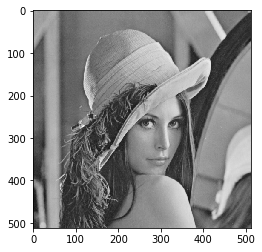

In [24]:
I = cv.imread('../data/lena.jpg', cv.IMREAD_GRAYSCALE)
show_img_bgr(I)

In [38]:
# step1. Expand the image to an optimal size
# DFT 的性能取决于图像大小，对于图像大小是数字2、3、5的倍数, 它往往是最快的; 
# 因此要获得最佳性能，通常最好将边框值填充到图像上以获得具有此类特征的尺寸
rows, cols = I.shape
m = cv.getOptimalDFTSize(rows)
n = cv.getOptimalDFTSize(cols)
padded = cv.copyMakeBorder(image, 0, m - rows, 0, n - cols, cv.BORDER_CONSTANT, value=[0, 0, 0])

In [82]:
## step2. Make place for both the complex and the real values
# 傅里叶变换的结果是复数形式，这意味着对于每个图像值，对应着两个值，而且频率域范围比其空间对应范围大得多。
# 因此，通常至少以浮点数存储这些内容。
planes = [np.float32(padded), np.zeros(padded.shape, np.float32)]
complexI = cv.merge(planes)         # Add to the expanded another plane with zeros

In [80]:
# step3. Make the Discrete Fourier Transform
# an in-place calculation
tmp = cv.dft(complexI, complexI)         # this way the result may fit in the source matrix

The magnitude of a DFT is:
![](../images/magnitude_of_dft.png)

In [52]:
# step4. Transform the real and complex values to magnitude
cv.split(complexI, planes)                 # planes[0] = Re(DFT(I), planes[1] = Im(DFT(I))
magI = cv.magnitude(planes[0], planes[1])  

In [58]:
# step5. Switch to a logarithmic scale
# 傅里叶系数的动态范围太大，无法在屏幕上显示，对于一些 some small and some high changing values, 不能被观察到
# 因为 High values 将全部显示为白色点, small values 将显示为黑色。
# 为了使用灰度值进行可视化，可以将线性比例转换为对数 M_new = log(1 + M)
matOfOnes = np.ones(magI.shape, dtype=magI.dtype)
magI = cv.add(matOfOnes, magI) # switch to logarithmic scale ,  dst = src1 + src2
magI = cv.log(magI)

In [59]:
# step6. Crop and rearrange
magI_rows, magI_cols = magI.shape

# crop the spectrum, if it has an odd number of rows or columns
magI = magI[0:(magI_rows & -2), 0:(magI_cols & -2)]

cx = int(magI_rows/2)
cy = int(magI_cols/2)

q0 = magI[0:cx, 0:cy]         # Top-Left - Create a ROI per quadrant
q1 = magI[cx:cx+cx, 0:cy]     # Top-Right
q2 = magI[0:cx, cy:cy+cy]     # Bottom-Left
q3 = magI[cx:cx+cx, cy:cy+cy] # Bottom-Right

tmp = np.copy(q0)               # swap quadrants (Top-Left with Bottom-Right)
magI[0:cx, 0:cy] = q3
magI[cx:cx + cx, cy:cy + cy] = tmp

tmp = np.copy(q1)               # swap quadrant (Top-Right with Bottom-Left)
magI[cx:cx + cx, 0:cy] = q2
magI[0:cx, cy:cy + cy] = tmp

In [63]:
# step7. normalize
cv.normalize(magI, magI, 0, 1, cv.NORM_MINMAX) # Transform the matrix with float values into a

array([[0.29998192, 0.21425827, 0.30008888, ..., 0.3811742 , 0.30008924,
        0.21426095],
       [0.27595538, 0.3408512 , 0.30253634, ..., 0.34051022, 0.29093698,
        0.29461336],
       [0.34195372, 0.26123086, 0.35128102, ..., 0.30068585, 0.32069325,
        0.29961038],
       ...,
       [0.27618915, 0.32839704, 0.3005096 , ..., 0.28231943, 0.26526153,
        0.3743575 ],
       [0.34195372, 0.2996116 , 0.3206947 , ..., 0.2381944 , 0.35128063,
        0.2612317 ],
       [0.275955  , 0.29461348, 0.29093626, ..., 0.3594323 , 0.30253476,
        0.34085155]], dtype=float32)

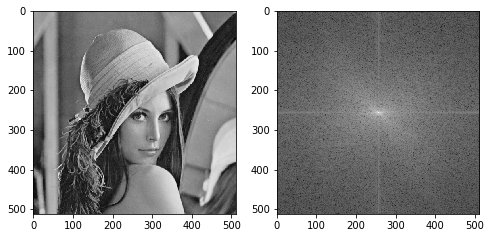

In [65]:
# step8. result
fig = plt.figure(figsize=(8, 12))
ax = fig.subplots(1, 2)
ax[0].imshow(I, cmap='gray')
ax[1].imshow(magI, cmap='gray')

## put together

In [73]:
def pipeline(image_path):
    
    I = cv.imread(cv.samples.findFile(image_path), cv.IMREAD_GRAYSCALE)
    
    if I is None:
        print('Error opening image')
        return -1
    
    rows, cols = I.shape
    m = cv.getOptimalDFTSize( rows )
    n = cv.getOptimalDFTSize( cols )
    padded = cv.copyMakeBorder(I, 0, m - rows, 0, n - cols, cv.BORDER_CONSTANT, value=[0, 0, 0])
    
    planes = [np.float32(padded), np.zeros(padded.shape, np.float32)]
    complexI = cv.merge(planes)         # Add to the expanded another plane with zeros
    
    cv.dft(complexI, complexI)         # this way the result may fit in the source matrix
    
    cv.split(complexI, planes)                   # planes[0] = Re(DFT(I), planes[1] = Im(DFT(I))
    cv.magnitude(planes[0], planes[1], planes[0])# planes[0] = magnitude
    magI = planes[0]
    
    matOfOnes = np.ones(magI.shape, dtype=magI.dtype)
    cv.add(matOfOnes, magI, magI) #  switch to logarithmic scale
    cv.log(magI, magI)
    
    magI_rows, magI_cols = magI.shape
    # crop the spectrum, if it has an odd number of rows or columns
    magI = magI[0:(magI_rows & -2), 0:(magI_cols & -2)]
    cx = int(magI_rows/2)
    cy = int(magI_cols/2)
    q0 = magI[0:cx, 0:cy]         # Top-Left - Create a ROI per quadrant
    q1 = magI[cx:cx+cx, 0:cy]     # Top-Right
    q2 = magI[0:cx, cy:cy+cy]     # Bottom-Left
    q3 = magI[cx:cx+cx, cy:cy+cy] # Bottom-Right
    tmp = np.copy(q0)               # swap quadrants (Top-Left with Bottom-Right)
    magI[0:cx, 0:cy] = q3
    magI[cx:cx + cx, cy:cy + cy] = tmp
    tmp = np.copy(q1)               # swap quadrant (Top-Right with Bottom-Left)
    magI[cx:cx + cx, 0:cy] = q2
    magI[0:cx, cy:cy + cy] = tmp
    
    cv.normalize(magI, magI, 0, 1, cv.NORM_MINMAX) # Transform the matrix with float values into a
    
    fig = plt.figure(figsize=(30, 24))
    ax = fig.subplots(1, 2)
    ax[0].imshow(I, cmap='gray')
    ax[0].set_title('Input Image', fontsize=20)
    ax[1].imshow(magI, cmap='gray')
    ax[1].set_title('spectrum magnitude', fontsize=20)

## 应用: 检测文本的的方向

一个应用的方法是确定图像中存在的几何方向。比如确定文本是水平还是竖直。

从下图可以看到: 频域中最具影响力的部分(幅度图像上最亮的点)跟随图像上对象的几何旋转。

因此，我们计算偏移量并执行图像旋转以校正。

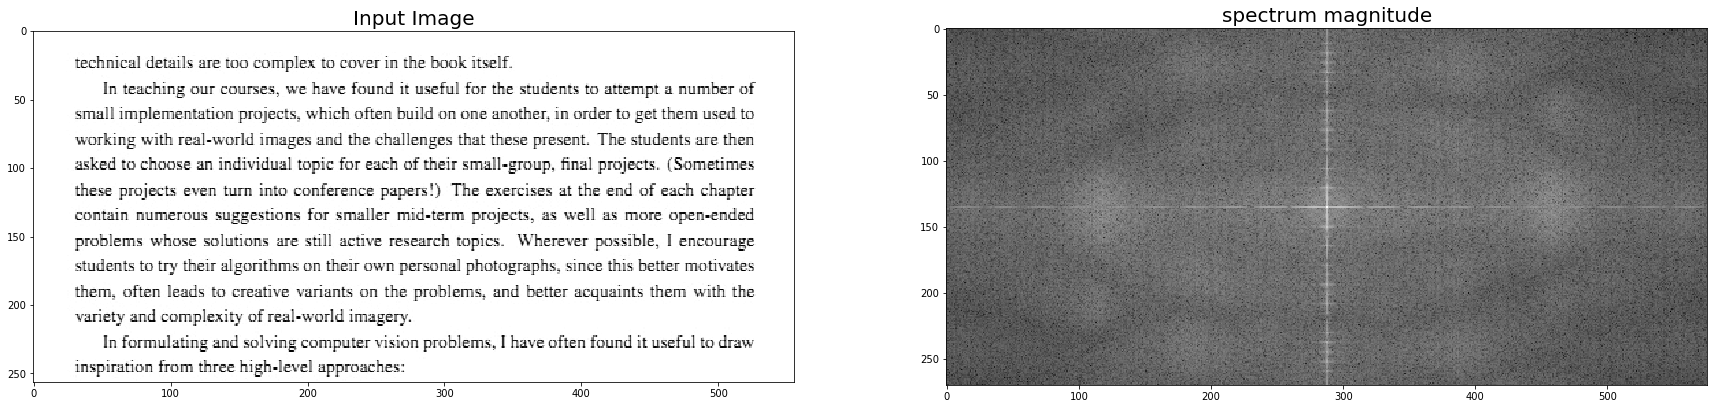

In [74]:
pipeline('../data/imageTextN.png')

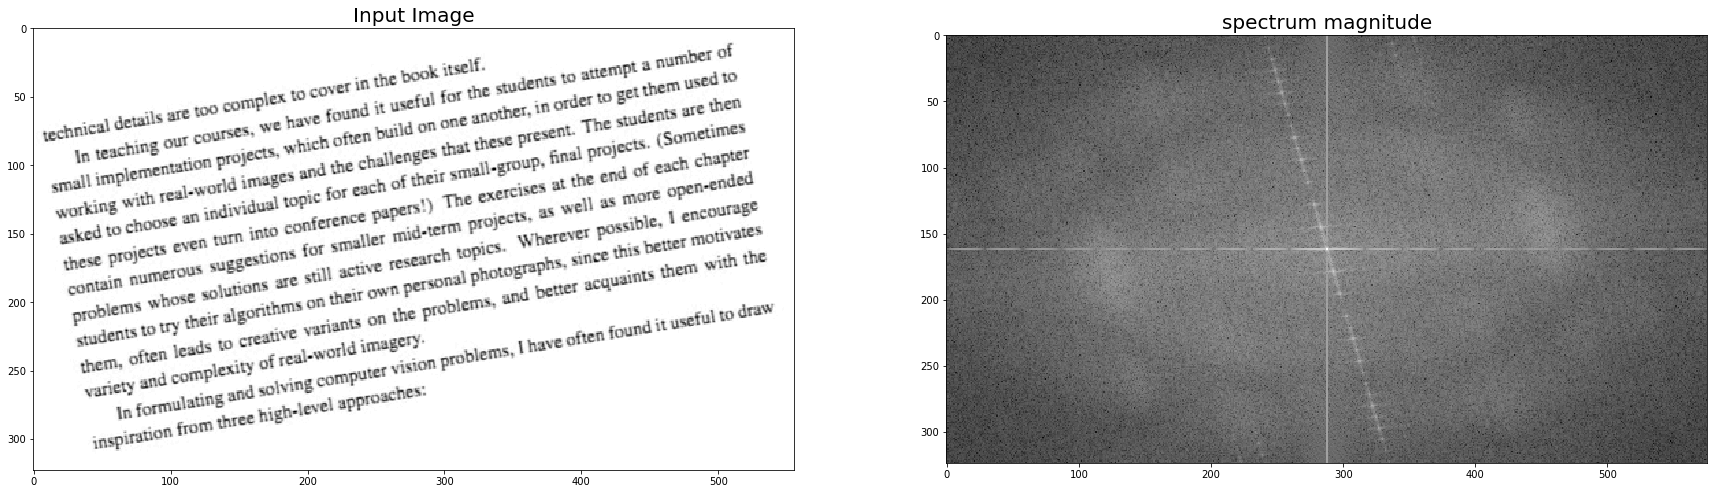

In [75]:
pipeline('../data/imageTextR.png')